In [9]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Normalize, Lambda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from unet import UNet

In [10]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Normalize(127.5, 127.5),
    ])
)

sample.shape torch.Size([3, 256, 256])
sample.min() tensor(-1.)
sample.max() tensor(1.)


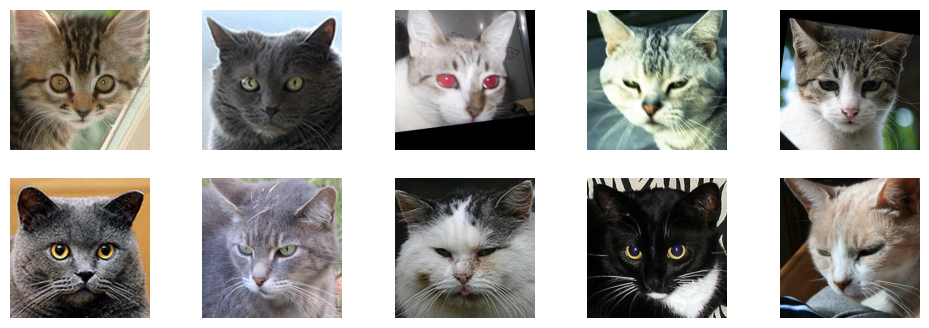

In [13]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [14]:
model = UNet(
    in_channels=3,
    out_channels=3,
    levels=3,
    time_emb_dim=128
).cuda()
diffusion = Diffusion(
    betas=get_named_beta_schedule('sigmoid', 1000)
)

In [ ]:
trainer = Trainer(
    diffusion,
    model,
    
)